In [60]:
%matplotlib notebook
%matplotlib inline

import os
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})


In [2]:
# experiment_id, experiment_name = "6yl48QRjSySDUpTg8TpeRw", "st_uc-bg_bigBugfixMetric_bs4_split_1_1_trial1_29d20f8"
# experiment_id, experiment_name = "zNo4qyA5RBybC9m0sPRiZw", "st_uc-bg_bigBugfixMetric_bs4_split_1_1_trial1_b4f39ae"
# experiment_id, experiment_name = "7M4Qi6dmQteoRpuOibFbWQ", "st_fg_uc_bg_pl_o_95_85_85_s_0_26729b3"
# experiment_id, experiment_name = "xsV7RvysQkyiriyOKoTJ6A", "iou_metrics_st_bs8_split_1_1_trial_1_ca74a38"
# experiment_id, experiment_name = "o7fRMElwRAKv6boGQb29FQ", "rev-uc-bg_bs8_split_1_1_trial_1_293070a"


# experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
# df = experiment.get_scalars()
# df.to_csv(f"metrics_{experiment_name}.csv", index=False)

# df = pd.read_csv(f"metrics_{experiment_name}.csv")

## Class distribution of GT boxes in unlabaled data

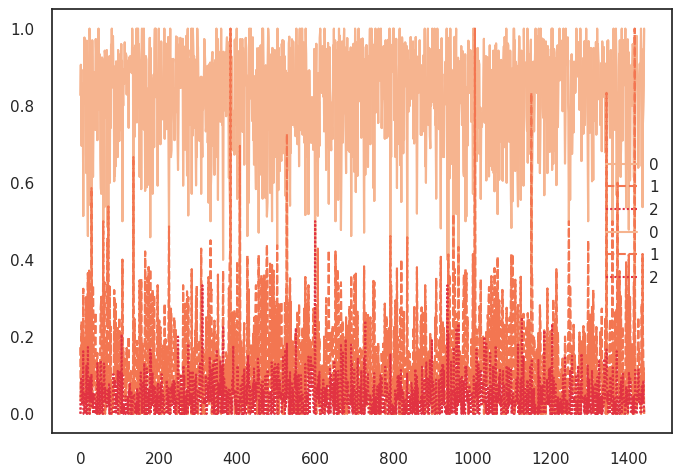

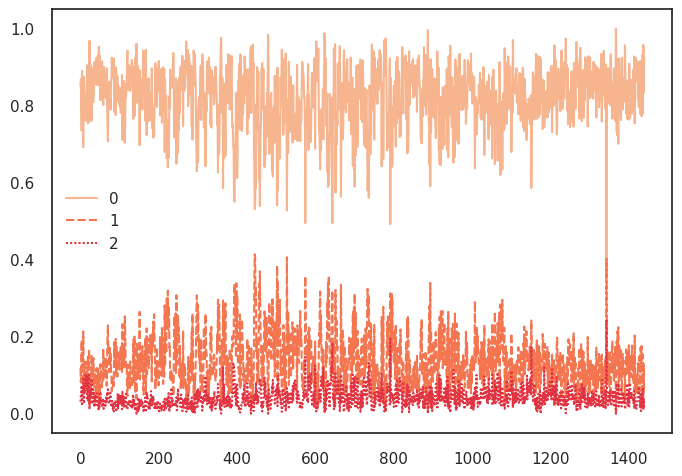

In [40]:
import torch
exp_id_ab1_ours, exp_name_ab1_ours = "o7fRMElwRAKv6boGQb29FQ", "rev-uc-bg_bs8_split_1_1_trial_1_293070a"
df = pd.read_csv(f"metrics_{exp_name_ab1_ours}.csv")
l = []
m = []
num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}
for cls_idx in list(num_to_class.keys()):
    x = df[df.run==('tensorboard/rcnn_roi_pl_gt_metrics_cls/num_gt_boxes/' + num_to_class[cls_idx])].reset_index().value.tolist()
    y = df[df.run==('tensorboard/rcnn_roi_pl_gt_metrics_cls/num_pred_boxes/' + num_to_class[cls_idx])].reset_index().value.tolist()
    l.append(x)
    m.append(y)
l = torch.Tensor(l).transpose(0,1)
l_sum = torch.sum(l, dim=1).unsqueeze(-1).repeat(1,3)
final_gt = torch.div(l, l_sum)
final_gt_df = pd.DataFrame(final_gt.numpy())
g = sns.lineplot(final_gt_df)
plt.show()
m = torch.Tensor(m).transpose(0,1)
m_sum = torch.sum(m, dim=1).unsqueeze(-1).repeat(1,3)
final_pred = torch.div(m, m_sum)
final_pred_df = pd.DataFrame(final_pred.numpy())
h = sns.lineplot(final_pred_df)
plt.show()


## Plot % of FG proposals

In [6]:
p = sns.color_palette('rocket')
def draw_metrics_num_fg(df, fname, tags=None, y_label=None, colors=None):
    f, axes = plt.subplots(1, 1, sharey=True, figsize=(6.5,4.5))
    base_run = "tensorboard"
    classes = ["Car", "Pedestrian", "Cyclist"]
    if colors is None : 
        colors = sns.color_palette('rocket', len(classes))
        palette = {'Car': p[2], 'Pedestrian':p[0], 'Cyclist': p[-2]}

    classwise_df=pd.DataFrame()
    org_classwise_df = pd.DataFrame()
    for cls_idx, (cls, color) in enumerate(zip(classes, colors)):
        run = base_run + "/" + tags + "/" + cls
        steps = df[df.run == run].step
        values = df[df.run == run].value
        smooth_values = df[df.run == run].ewm(alpha=0.1).mean().value
        # store all classwise IoUs in a single dataframe and plot all at once
        classwise_df[cls] = smooth_values.reset_index(drop=True)
        org_classwise_df[cls] = values.reset_index(drop=True)
            
    sns.lineplot(ax=axes, data=classwise_df, linewidth=2, dashes=False, legend = True, palette=palette)
    sns.lineplot(ax=axes, data=org_classwise_df, linewidth=1, dashes=False, legend = False, palette=palette, alpha = 0.3)

    # x/y ticks
    axes.yaxis.set_tick_params(labelleft=True, labelsize='small')
    axes.xaxis.set_tick_params(labelbottom=False)
    axes.yaxis.grid(True, linestyle='--', alpha=0.5)

    legend = axes.legend(frameon = True, fontsize=10, ncol=3, framealpha = 0.7)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')

    # common plot labels
    f.text(0.5, -0.01, "Training iterations", ha='center')
    f.text(-0.01, 0.5, y_label, va='center', rotation='vertical')
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=fname, transparent=False, bbox_inches='tight')

####################################################################
# Plot setting and theme
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

# --------------- Ablation 1 ---------------
exp_id_ab1_ours, exp_name_ab1_ours = "f5nMZ6K9SySkIYEEP1J2jw", "st_fg_uc_bg_pl_o_95_85_85_s_0_26729b3"
df_ab1_ours = pd.read_csv(f"metrics_{exp_name_ab1_ours}.csv")

# --------------- Raw IoUs based on FG ---------------
tag = "rcnn_roi_pl_gt_metrics_cls/pred_fgs"
y_label = '% of foreground ROIs wrt ground truths'
fname = f"pred_fgs.pdf"

draw_metrics_num_fg(df=df_ab1_ours, fname=fname, tags=tag, y_label=y_label)

## Plot TP/FP/FN weights

In [5]:
def draw_tp_fp_fn_weight_plot(df, fname, tags=None, tag_names=None, threshs=None, y_label=None):
    f, axes = plt.subplots(1, 3, sharey=True, figsize=(12,4))
    base_run = "tensorboard"
    classes = ["Car", "Pedestrian", "Cyclist"]
    p = sns.color_palette('rocket')
    palette = [p[-2], p[0], p[2]]
    for j, cls in enumerate(classes):
        for k, (tag, tname) in enumerate(zip(tags, tag_names)):
            run = base_run + "/" + tag + "/" + cls
            steps = df[df.run == run].step
            values = df[df.run == run].value
            smooth_values = df[df.run == run].ewm(alpha=0.2).mean().value
            
            # plot raw values with transperancy 
            sns.lineplot(ax=axes[j], x=steps, y=values, alpha=0.2, color=palette[k], lw=1)
            
            # plot smooth values
            if j == 0:
                sns.lineplot(ax=axes[j], x=steps, y=smooth_values, label=tname, color=palette[k], lw=1.5)
                axes[j].set_ylabel(y_label)
            else:
                sns.lineplot(ax=axes[j], x=steps, y=smooth_values, color=palette[k], lw=1.5)

        if j==0:
            axes[j].yaxis.set_tick_params(labelleft=True, labelsize="small")
        axes[j].set_xlabel("Training iterations")
        axes[j].xaxis.set_tick_params(labelsize="small")
        axes[j].set_title(cls)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)

    legend = axes[0].legend(frameon = True, fontsize=9, framealpha = 0.7)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')

    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.02)
    f.savefig(fname=fname, transparent=False, bbox_inches='tight')

# --------------- TP/FP/FN weights ---------------
# exp_id_ab1_ours, exp_name_ab1_ours = "xsV7RvysQkyiriyOKoTJ6A", "iou_metrics_st_bs8_split_1_1_trial_1_ca74a38"
exp_id_ab1_ours, exp_name_ab1_ours = "o7fRMElwRAKv6boGQb29FQ", "rev-uc-bg_bs8_split_1_1_trial_1_293070a"
df_ab1_ours = pd.read_csv(f"metrics_{exp_name_ab1_ours}.csv")

tags = ["rcnn_roi_pl_gt_metrics_cls/pred_weight_tp", "rcnn_roi_pl_gt_metrics_cls/pred_weight_fp", "rcnn_roi_pl_gt_metrics_cls/pred_weight_fn"]
tag_names = ["TP weights", "FP weights", "FN weights"]
y_label = "Mean assignment weight"
draw_tp_fp_fn_weight_plot(df_ab1_ours, fname=f"pred_weights_tp_fp_fn.png", tags=tags, y_label=y_label, tag_names=tag_names)

In [ ]:
# # --------------- TP/FP/FN rates ---------------
# tags = ["rcnn_roi_pl_gt_metrics_cls/pred_tp_rate", "rcnn_roi_pl_gt_metrics_cls/pred_fp_ratio", "rcnn_roi_pl_gt_metrics_cls/pred_fn_rate"]
# tag_names = ["TP Rate", "FP Ratio", "FN Rate"]
# y_label = "Ratio"
# colors = ['green', 'blue', 'red']
# draw_metrics(dfs=dfs, fname=f"fp_fn_{exp_name_ab1_default}.png", tags=tags[1:], y_label=y_label, tag_names=tag_names[1:], colors = colors[1:])
# draw_metrics(dfs=dfs, fname=f"tp_{exp_name_ab1_default}.png", tags=[tags[0]], y_label=y_label, tag_names=[tag_names[0]])



# # --------------- Raw IoUs based on TP/FP/FN ---------------
# tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_tp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fn"]
# y_label = "ROI IoU wrt. pseudo-labels"
# fname = f"roi_iou_wrt_pl_ab1_default_{exp_name_ab1_default}.png"
# threshs = np.array([[0.75, 0.75, 0.75], [0.65, 0.45, 0.4]])
# draw_metrics_iou(dfs=dfs, fname=fname, threshs=threshs, tags=tags, y_label=y_label)

# # --------------- Correlation between FG IoUs and weights ---------------
# tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fg", "rcnn_roi_pl_gt _metrics_cls/pred_weight_fg"]
# y_label = "Weights"
# # tag_names = ["FG ROI IoU wrt. pseudo-labels"]
# fname = f"correlation_ab1_default_{exp_name_ab1_default}.png"
# # threshs = np.array([[0.75, 0.75, 0.75], [0.65, 0.45, 0.4]])
# draw_metrics_correlation(dfs=dfs, fname=fname, tags=tags, y_label=y_label)

## Classwise thresholds - FG IoUs between ROIs and PLs 

### 1. FG IoUs every 64th sample

In [ ]:
p = sns.color_palette('rocket')
def draw_metrics_fg_ious(dfs, fname, tags=None, tag_names=None, threshs=None, y_label=None, colors=None):
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,5))
    base_run = "tensorboard"
    if y_label is None:
        y_label = "ROI IoU wrt. pseudo-labels"
    classes = ["Car", "Pedestrian", "Cyclist"]
    class_thresh = [0.65, 0.45, 0.4]
    if tags is None:
        tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_tp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fn"]
    if tag_names is None:
        tag_names = ["True Positive ROIs", "False Positive ROIs", "False Negative ROIs"]
    if colors is None : 
        colors = sns.color_palette('rocket', len(classes))
        # palette = {mode: color for mode, color in zip(classes, colors)}
        palette = {'Car': p[2], 'Pedestrian':p[0], 'Cyclist': p[-2]}
    subplot_titles = ['Before', 'After']
    
    for j in range(len(subplot_titles)):
        df = dfs[j]
        classwise_df=pd.DataFrame()
        org_classwise_df = pd.DataFrame()
        for cls_idx, (cls, color) in enumerate(zip(classes, colors)):
            for k, (tag, tname) in enumerate(zip(tags, tag_names)):
                run = base_run + "/" + tag + "/" + cls
                steps = df[df.run == run].step
                values = df[df.run == run].value
                smooth_values = df[df.run == run].ewm(alpha=0.1).mean().value
                # store all classwise IoUs in a single dataframe and plot all at once
                classwise_df[cls] = smooth_values.reset_index(drop=True)
                org_classwise_df[cls] = values.reset_index(drop=True)
            
            # plot threshold lines 
            if j == 0 and cls_idx == 0:
                if threshs is not None:
                    axes[j].axhline(y=threshs[j][cls_idx], linestyle=":", label="$\\tau=0.75$", color='black', alpha=0.9, lw=1.8)
            if j == 1:
                if threshs is not None:
                    label = "$\\tau_{cls}=thresh$".replace('cls', cls).replace('thresh', str(class_thresh[cls_idx]))
                    axes[j].axhline(y=threshs[j][cls_idx], linestyle=":", label=label, color=palette[cls], alpha=0.9, lw=1.8)
                axes[j].yaxis.set_tick_params(labelleft=True)
        
        # plot ious
        if j == 0:
            sns.lineplot(ax=axes[j], data=classwise_df, linewidth=1.5, dashes=False, legend = True, palette=palette)
            sns.lineplot(ax=axes[j], data=org_classwise_df, linewidth=1, dashes=False, legend = False, palette=palette, alpha = 0.2)
        else:
            sns.lineplot(ax=axes[j], data=classwise_df, linewidth=1.5, dashes=False, legend = True, palette=palette)
            sns.lineplot(ax=axes[j], data=org_classwise_df, linewidth=1, dashes=False, legend = False, palette=palette, alpha = 0.2)
        
        # x/y ticks
        axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
        axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
        axes[j].xaxis.set_tick_params(labelbottom=False)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
        # legends
        handles, labels = axes[j].get_legend_handles_labels()

        order = [0,3,1,4,2,5] if j == 1 else [0,1,2,3]
        ncol = 3 if j==1 else 4

        # Add IoU in legends if needed using below code
        # Note : Needs latex related libraries installed in the env
        # new_labels = []
        # new_handles = []
        # for idx in order:
        #     new_handles.append(handles[idx])
        #     if idx%2!=0:
        #         new_labels.append(r"IoU_{cls}")
        #     else:
        #         new_labels.append(labels[idx])
        # legend = axes[j].legend(new_handles,new_labels, frameon = 1, ncol=3)
        legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7)
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')

    # common plot labels
    f.text(0.5, -0.01, "$Training\enspaceiterations$", ha='center')
    f.text(-0.01, 0.5, y_label, va='center', rotation='vertical')
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=fname, transparent=False, bbox_inches='tight')

####################################################################
# Plot setting and theme
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

# --------------- Ablation 1 ---------------
exp_id_ab1_default, exp_name_ab1_default = "dTrxKmgMRQK122Hm1cmaPA", "ablation1_bs8_split_1_1_trial_3_5802d99"
exp_id_ab1_ours, exp_name_ab1_ours = "f5nMZ6K9SySkIYEEP1J2jw", "st_fg_uc_bg_pl_o_95_85_85_s_0_26729b3"
df_ab1_default = pd.read_csv(f"metrics_{exp_name_ab1_default}.csv")
df_ab1_ours = pd.read_csv(f"metrics_{exp_name_ab1_ours}.csv")
dfs = [df_ab1_default, df_ab1_ours]

# --------------- Raw IoUs based on FG ---------------
tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fg"]
y_label = '$FG\enspaceIoU_{ROI, PL}$'
fname = f"fg_roi_iou_wrt_pl_ab1.png"
threshs = np.array([[0.75, 0.75, 0.75], [0.65, 0.45, 0.4]])
draw_metrics_fg_ious(dfs=dfs, fname=fname, threshs=threshs, tags=tags, y_label=y_label)

In [61]:
import pandas as pd
import numpy as np
import torch
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})
# cmap = ListedColormap(sns.color_palette("tab10")) # earlier tab10
cmap = sns.color_palette("rocket_r", as_cmap=True)
_cmap = sns.color_palette("rocket", as_cmap=True)

df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_new.pkl') # iou_metrics_st_bs8_split_1_1_trial_1_d16ba20
baseline_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_baseline.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_ablation1.pkl')
fp_uc_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_fp_uc.pkl') # fp_rev_uc-bg_007_bs8_split_1_1_trial_1_8362d99

## Pie chart for number of ROIs in different regions

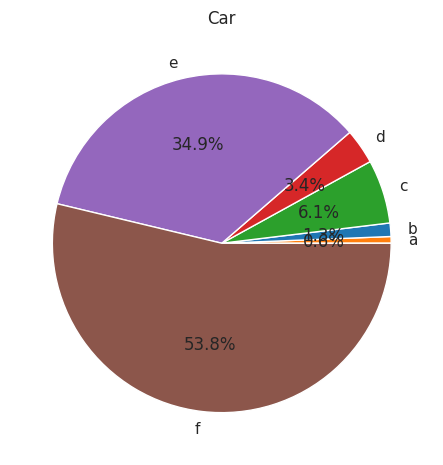

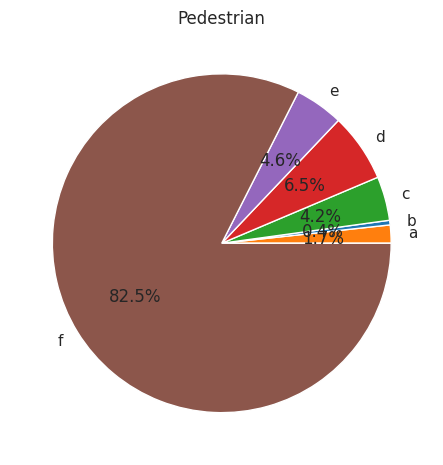

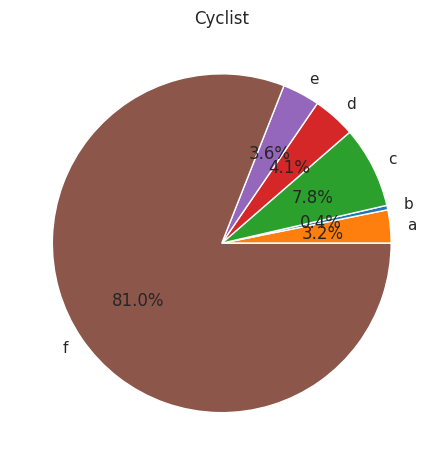

In [73]:
num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}
fg_thresh = [0.7,0.5,0.5]
local_fg_thresh = [0.65,0.45,0.4]

class_count = {'Car': {}, 'Pedestrian': {}, 'Cyclist': {}}
mask = {'a': None, 'b': None, 'c': None, 'd': None, 'e': None, 'f': None}
for cls_idx, cls_name in num_to_class.items():
    class_mask = (torch.Tensor(fp_uc_df['class_labels'])==cls_idx)
    # a
    mask['a'] = class_mask & (torch.Tensor(fp_uc_df['iou_roi_gt']) > local_fg_thresh[cls_idx-1]) & (torch.Tensor(fp_uc_df['iou_roi_pl']) < 0.25)
    # b
    mask['b'] = class_mask & (torch.Tensor(fp_uc_df['iou_roi_gt']) > local_fg_thresh[cls_idx-1]) & (torch.Tensor(fp_uc_df['iou_roi_pl']) < local_fg_thresh[cls_idx-1]) & (torch.Tensor(fp_uc_df['iou_roi_pl']) > 0.25)
    # c
    mask['c'] = class_mask & (torch.Tensor(fp_uc_df['iou_roi_gt']) > local_fg_thresh[cls_idx-1]) & (torch.Tensor(fp_uc_df['iou_roi_pl']) > local_fg_thresh[cls_idx-1])
    # d
    mask['d'] = class_mask & (torch.Tensor(fp_uc_df['iou_roi_gt']) < local_fg_thresh[cls_idx-1]) & (torch.Tensor(fp_uc_df['iou_roi_pl']) > local_fg_thresh[cls_idx-1])
    # e
    mask['e'] = class_mask & (torch.Tensor(fp_uc_df['iou_roi_gt']) < local_fg_thresh[cls_idx-1]) & (torch.Tensor(fp_uc_df['iou_roi_pl']) < local_fg_thresh[cls_idx-1]) & (torch.Tensor(fp_uc_df['iou_roi_pl']) > 0.25)
    # f
    mask['f'] = class_mask & (torch.Tensor(fp_uc_df['iou_roi_gt']) < local_fg_thresh[cls_idx-1]) & (torch.Tensor(fp_uc_df['iou_roi_pl']) < 0.25)

    for key in mask.keys():
        if torch.count_nonzero(mask[key]) != None:
            class_count[cls_name][key] = torch.count_nonzero(mask[key]).item()

for class_name in class_count.keys():
    plt.pie(class_count[class_name].values(), labels=class_count[class_name].keys(), autopct='%1.1f%%', colors=['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    plt.title(class_name)
    plt.show()



## Plot of IOU (roi,gt) and Student's pred scores

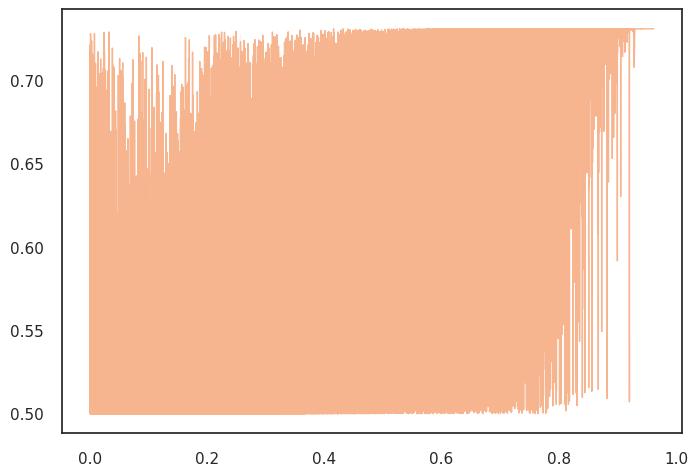

In [11]:
pred_scores = torch.sigmoid(torch.Tensor(df['pred_scores'])).tolist()
df['pred_scores'] = pred_scores
l = sns.lineplot(data=df, x=df['iou_roi_gt'], y=df['pred_scores'], linewidth=1, dashes=False, legend = True)
plt.show()

### 2. FG IoUs every iteration

In [ ]:
def get_fg_iou_plot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,5))
    thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}
    
    p = sns.color_palette('rocket')
    colors = sns.color_palette('rocket', len(thresh))
    palette = {'Car': p[2], 'Pedestrian':p[0], 'Cyclist': p[-2]}

    for j in range(2):
        df = dfs[j]

        fg_iou_roi_pl_df = pd.DataFrame({'iteration': np.arange(0,1440)})
        fg_iou_roi_pl_df['Car'] = np.nan
        fg_iou_roi_pl_df['Pedestrian'] = np.nan
        fg_iou_roi_pl_df['Cyclist'] = np.nan

        for cls_idx, cls_name in num_to_class.items():
            cls_mask = torch.Tensor(df['class_labels'])==cls_idx
            fg_mask = torch.Tensor(df['iou_roi_gt']) >= fg_thresh[cls_idx-1]
            valid_mask = cls_mask & fg_mask

            aux_df = pd.DataFrame()
            aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])[valid_mask]
            aux_df['iteration'] = torch.Tensor(df['iteration'])[valid_mask]
            fg_iou_roi_pl = aux_df.groupby('iteration')['iou_roi_pl'].mean().reset_index()
            # print(fg_iou_roi_pl)
            for idx, _ in fg_iou_roi_pl_df.iterrows():
                if fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].size != 0:
                    fg_iou_roi_pl_df.at[idx, cls_name] = fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0]

            # plot threshold lines 
            if j == 0 and cls_idx == 1:
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label="$\\tau=0.75$", color='black', alpha=0.9, lw=1.8)
            if j == 1:
                label = "$\\tau_{cls}=thresh$".replace('cls', cls_name).replace('thresh', str(thresh[j][cls_idx-1]))
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label=label, color=palette[cls_name], alpha=0.9, lw=1.8)
            axes[j].yaxis.set_tick_params(labelleft=True)
    
        # plot ious
        fg_iou_roi_pl_df = fg_iou_roi_pl_df.drop(['iteration'], axis=1)
        sns.lineplot(ax=axes[j], data=fg_iou_roi_pl_df.ewm(alpha=0.1).mean(), linewidth=1, dashes=False, legend = True, palette=palette)
        sns.lineplot(ax=axes[j], data=fg_iou_roi_pl_df, linewidth=0.8, dashes=False, legend = False, palette=palette, alpha = 0.1)

        # x/y ticks
        # axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
        axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
        axes[j].xaxis.set_tick_params(labelbottom=False)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
        # legends
        handles, labels = axes[j].get_legend_handles_labels()

        order = [0,3,1,4,2,5] if j == 1 else [0,1,2,3]
        ncol = 3 if j==1 else 4
        if j==0:
            legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                    frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="upper left")
        else:
            legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                    frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
    
    # common plot labels
    f.text(0.5, -0.01, "$Training\enspaceiterations$", ha='center')
    f.text(-0.01, 0.5, '$FG\enspaceIoU_{ROI, PL}$', va='center', rotation='vertical')
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=f"fg_roi_iou_wrt_pl_ab1.png", transparent=False, bbox_inches='tight')

#! TODO : change baseline dataframe to ablation 1 dataframe !!
dfs = [ablation1_df, df]
get_fg_iou_plot(dfs)

## % of FG IoUs crossing local thresh using Barplot

In [ ]:
def get_fg_iou_barplot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(1, 1, sharey=True, figsize=(6.5,2.5))
    thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}
    
    p = sns.color_palette('rocket')
    colors = sns.color_palette('rocket', len(thresh))
    palette = {'Car': p[2], 'Pedestrian':p[0], 'Cyclist': p[-2]}
    combined_df = pd.DataFrame()
    for j in range(2):
        experiment = 'Class-agnostic local thresholds' if j==0 else 'Class-wise local thresholds'
        df = dfs[j]
        
        aux_df = pd.DataFrame()
        aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])
        aux_df['iou_roi_gt'] = torch.Tensor(df['iou_roi_gt'])
        aux_df['iteration'] = torch.Tensor(df['iteration'])
        aux_df['class_labels'] = torch.Tensor(df['class_labels'])

        condition1 = (aux_df['class_labels']==1) & (aux_df['iou_roi_gt']<0.7)
        condition2 = (aux_df['class_labels']==2) & (aux_df['iou_roi_gt']<0.5)
        condition3 = (aux_df['class_labels']==3) & (aux_df['iou_roi_gt']<0.5)
        fg_df = aux_df.drop(aux_df[condition1 | condition2 | condition3].index)

        classwise_dict = {'Car': None, 'Pedestrian': None, 'Cyclist': None}
        fg_percent = {}
        for cls_idx, cls_name in enumerate(num_to_class.values()):
            classwise_df = pd.DataFrame()
            classwise_df = fg_df[fg_df['class_labels']==(cls_idx+1)]
            classwise_dict[cls_name] = classwise_df
            fg_percent[cls_name] = len(classwise_df[classwise_df['iou_roi_pl'] > thresh[j][cls_idx]]) / len(classwise_df)
            combined_df = combined_df.append({'Experiment': experiment, 'class_labels': cls_name, 'fg_percent': fg_percent[cls_name]}, ignore_index=True)

    ax = sns.barplot(data=combined_df, x="fg_percent", y="class_labels", hue="Experiment", palette="rocket_r", width=0.25, orient="h")
    ax.set(xlabel="Recall of targets for unlabeled RCNN classification loss", ylabel=None)
    patches = ax.patches
    for i in range(len(patches)):
        x = patches[i].get_width() + 0.04
        y = patches[i].get_y() + patches[i].get_height()/2 + 0.05
        ax.annotate('{:.1f}%'.format(list(combined_df['fg_percent']*100)[i]), (x, y), ha='center', color="black", size=9)

    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xticklabels(np.arange(0, 110, 10))
    ax.yaxis.set_tick_params(labelleft=True, labelsize='small')
    ax.xaxis.set_tick_params(labelbottom=True, labelsize='small')
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)
    legend = ax.legend(frameon = True, ncol=1, fontsize=8.5, framealpha = 0.5, loc='best', bbox_to_anchor=(0.99, 0.8))
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    plt.show()
    
    f.tight_layout()
    f.savefig(fname=f"cls_target_recall.pdf", transparent=False, bbox_inches='tight')

dfs = [ablation1_df, df]
get_fg_iou_barplot(dfs)

dfs = [df, df]
get_fg_iou_barplot(dfs)

## Scatterplot of IoUs wrt PL and GT over all iterations

In [ ]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())



def get_joint_plot(df, class_name, fig_title="Default", plot_type="joint"):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    epoch_mask = torch.Tensor(df['iteration']).int() > 1339
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < pl_thresh['BG']))
    valid_mask = class_mask & epoch_mask & ignore_bg_mask

    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            #'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

    if plot_type=='kde':
        g = sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap="Reds", shade=True, bw_adjust=.5)
        plt.show()
    else:
        g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", alpha=0.5, s=10)
        g.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)
        
        plt.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color='red', label="$\\tau_{local-fg}=var$".replace('var', str(pl_thresh['FG'][class_name])), alpha = 0.7, lw=2.5)
        plt.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color='orange', label="$\\tau_{local-bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2.5)
        plt.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color='black', label="$\\tau_{fg}=var$".replace('var', str(gt_thresh['FG'][class_name])), alpha = 0.7, lw=2.5)
        plt.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2.5)
        legend = plt.legend(frameon=True, fontsize=8, loc='lower left', borderpad=0.2, framealpha = 0.6)
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
    return g

car_plot_before = get_joint_plot(baseline_df, 'Car', "Before")
car_plot_after = get_joint_plot(df, 'Car', "After")

ped_plot_before = get_joint_plot(baseline_df, 'Pedestrian', "Before")
ped_plot_after = get_joint_plot(df, 'Pedestrian', "After")

cyc_plot_before = get_joint_plot(baseline_df, 'Cyclist', "Before")
cyc_plot_after = get_joint_plot(df, 'Cyclist', "After")

fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(2, 3)

#before
mg0 = SeabornFig2Grid(car_plot_before, fig, gs[0])
mg1 = SeabornFig2Grid(ped_plot_before, fig, gs[1])
mg2 = SeabornFig2Grid(cyc_plot_before, fig, gs[2])
#after
mg3 = SeabornFig2Grid(car_plot_after, fig, gs[3])
mg4 = SeabornFig2Grid(ped_plot_after, fig, gs[4])
mg5 = SeabornFig2Grid(cyc_plot_after, fig, gs[5])

gs.tight_layout(fig)
fig.savefig(fname="ious_old_scatter.png", transparent=False, bbox_inches='tight')
plt.show()


## Scatter Plot for IoUs wrt PL and GT + Assigned Weights for all the samples over last few iterations 

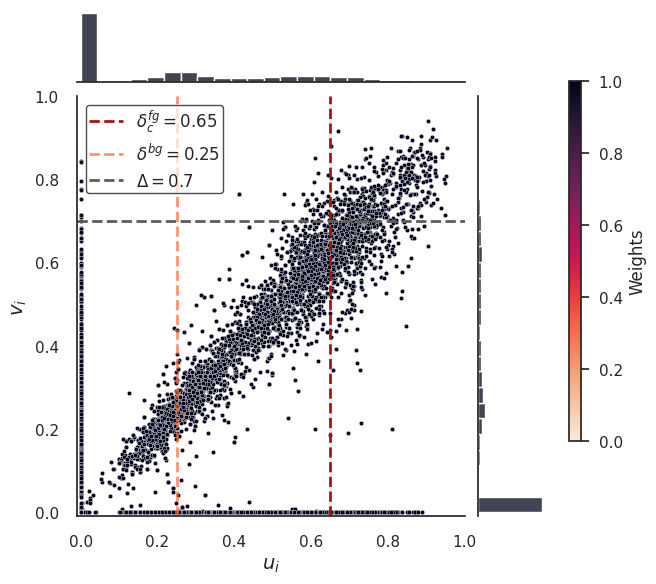

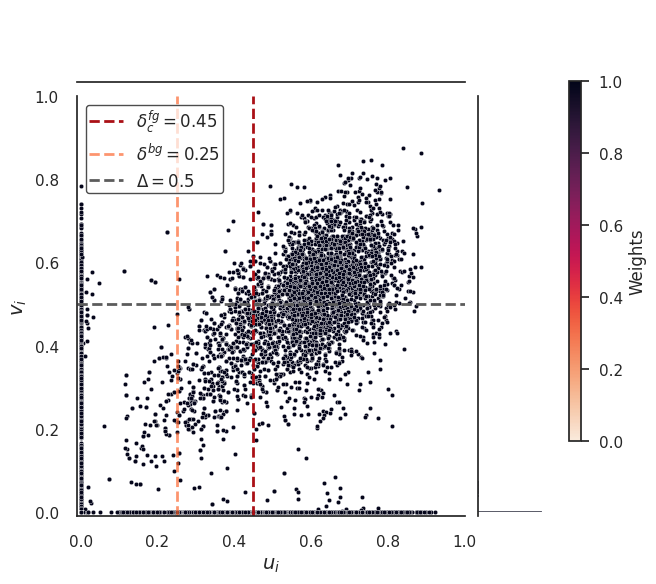

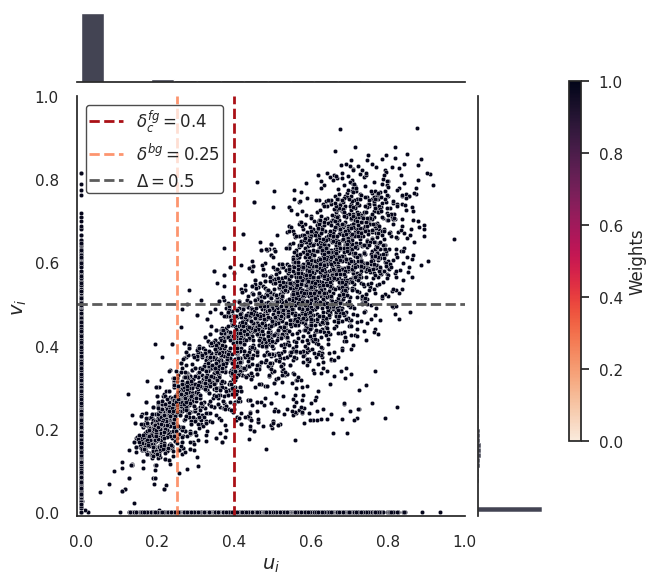

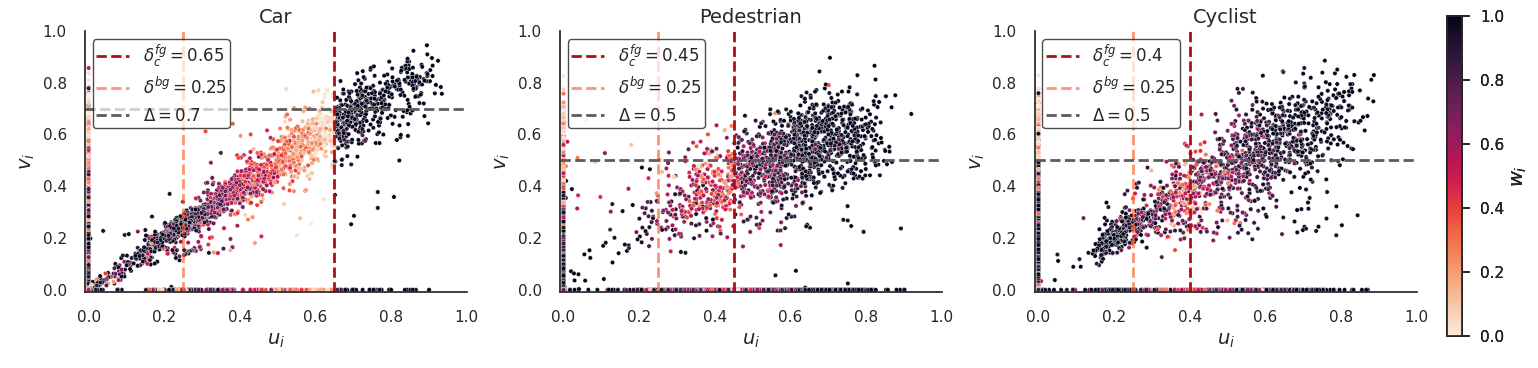

In [40]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec, class_name, disable_marginal_plot=True):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        self.disable_marginal_plot = disable_marginal_plot
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid(class_name)
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self, class_name):
        """ Move Jointgrid """
        self.sg.ax_joint.set_title(class_name, fontsize=14)
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        # disable marginal plots 
        if not self.disable_marginal_plot:
            self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
            self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])
        
        left_pos = 0.97 if self.disable_marginal_plot else 1
        # Make space for the colorbar
        self.fig.subplots_adjust(right=1.2)
        # Define a new Axes where the colorbar will go
        cax = self.fig.add_axes([left_pos, 0.1, .01, 0.80])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=cmap)
        # Draw the colorbar
        self.fig.colorbar(points, cax=cax).set_label("$w_{i}$", fontsize=14)

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


def get_joint_plot(df, class_name, fig_title="Default", plot_type="joint", epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = 1439-(24*epoch_num)

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < pl_thresh['BG']))
    valid_mask = class_mask & epoch_mask #& ignore_bg_mask

    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

    if plot_type=='kde':
        g = sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap=cmap, palette="rocket_r", shade=True, bw_adjust=.5)
        plt.show()
    else:
        if fig_title=='Before':
            color = _cmap(1)
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", color=color, xlim=-0.01, ylim=-0.01, legend=True, palette="rocket_r", s=10)
        else:
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", hue='weights', xlim=-0.01, ylim=-0.01, legend=False, palette="rocket_r", s=10)
        g.set_axis_labels('$u_{i}$', '$v_{i}$', fontsize=14)
    
        plt.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color=sns.color_palette("Reds")[-1], label="$\\delta^{fg}_{c}=var$".replace('var', str(pl_thresh['FG'][class_name])), lw=2)
        plt.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color=sns.color_palette('YlOrRd')[-3], label="$\\delta^{bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
        plt.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color=sns.color_palette("Greys")[-2], label="$\\Delta=var$".replace('var', str(gt_thresh['FG'][class_name])), lw=2)
        # plt.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)

        legend = plt.legend(bbox_to_anchor=(0.2, 1), frameon=True, fontsize=12, loc='upper center', borderpad=0.2, framealpha = 0.7) #'lower left'
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')

        # Make space for the colorbar
        g.fig.subplots_adjust(right=.92)
        # Define a new Axes where the colorbar will go
        cax = g.fig.add_axes([.96, .25, .02, .6])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=cmap)
        # Draw the colorbar
        g.fig.colorbar(points, cax=cax).set_label("Weights")
        # plt.show()
    return g

car_plot_before = get_joint_plot(baseline_df, 'Car', "Before", epoch_num=0.50)
car_plot_after = get_joint_plot(df, 'Car', "After", epoch_num=0.50)

ped_plot_before = get_joint_plot(baseline_df, 'Pedestrian', "Before", epoch_num=14)
ped_plot_after = get_joint_plot(df, 'Pedestrian', "After", epoch_num=14)

cyc_plot_before = get_joint_plot(baseline_df, 'Cyclist', "Before", epoch_num=24)
cyc_plot_after = get_joint_plot(df, 'Cyclist', "After", epoch_num=24)

fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 3)

# disable the marginal plots using this flag
disable_marginal_plot = True
#before
# mg0 = SeabornFig2Grid(car_plot_before, fig, gs[0], disable_marginal_plot)
# mg1 = SeabornFig2Grid(ped_plot_before, fig, gs[1], disable_marginal_plot)
# mg2 = SeabornFig2Grid(cyc_plot_before, fig, gs[2], disable_marginal_plot)
#after
mg3 = SeabornFig2Grid(car_plot_after, fig, gs[0], 'Car', disable_marginal_plot)
mg4 = SeabornFig2Grid(ped_plot_after, fig, gs[1], 'Pedestrian', disable_marginal_plot)
mg5 = SeabornFig2Grid(cyc_plot_after, fig, gs[2], 'Cyclist', disable_marginal_plot)

gs.tight_layout(fig)
fig.savefig(fname="ious_weights.png", transparent=False, bbox_inches='tight')
plt.show()


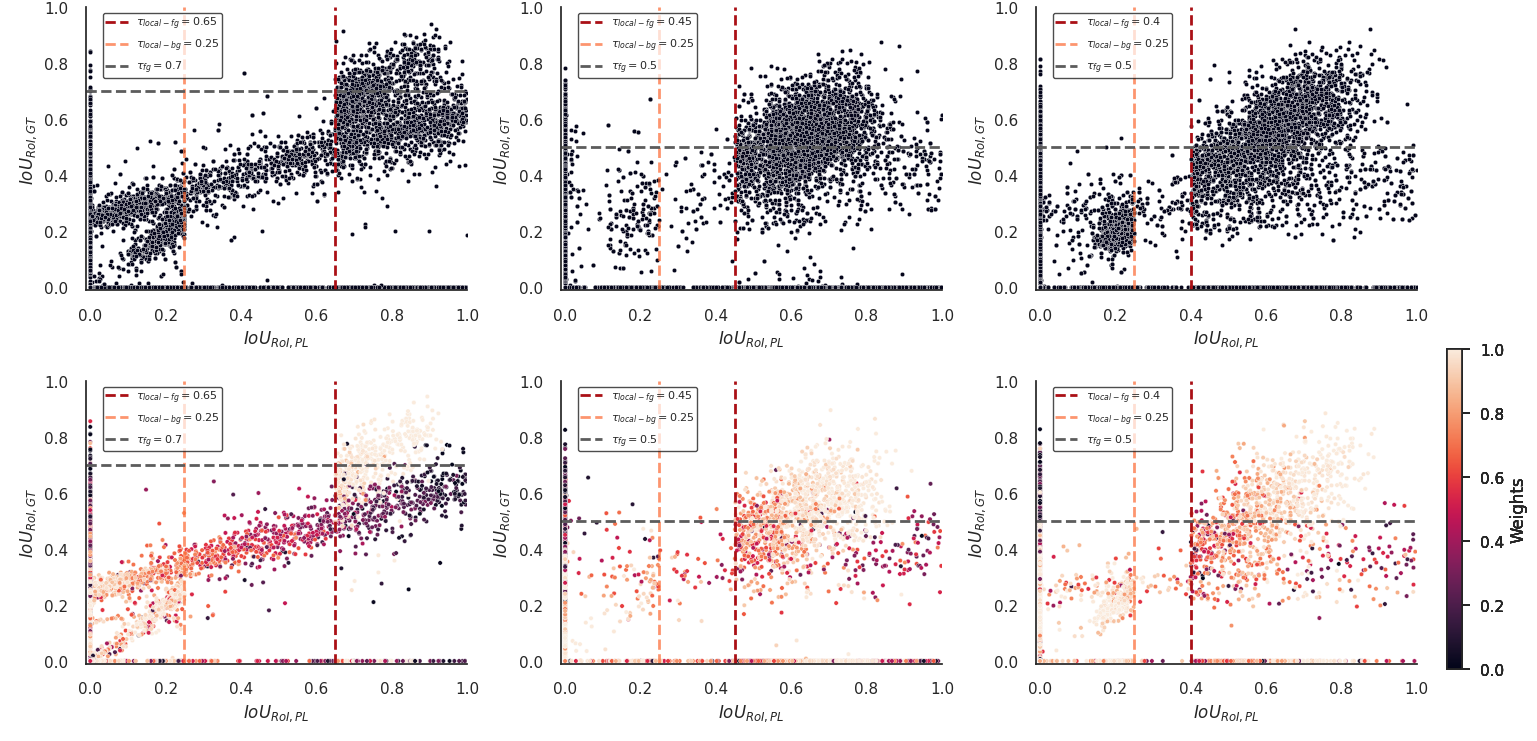

In [14]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec, disable_marginal_plot=True):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        self.disable_marginal_plot = disable_marginal_plot
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        # disable marginal plots 
        if not self.disable_marginal_plot:
            self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
            self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])
        
        left_pos = 0.97 if self.disable_marginal_plot else 1
        # Make space for the colorbar
        self.fig.subplots_adjust(right=1.2)
        # Define a new Axes where the colorbar will go
        cax = self.fig.add_axes([left_pos, 0.1, .01, 0.40])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=_cmap)
        # Draw the colorbar
        self.fig.colorbar(points, cax=cax).set_label("Weights")

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


def get_joint_plot(df, class_name, fig_title="Default", plot_type="joint", epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = 1439-(24*epoch_num)

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < pl_thresh['BG']))
    valid_mask = class_mask & epoch_mask #& ignore_bg_mask

    # calibrate UC IoUs
    iou_roi_pl = torch.Tensor(df['iou_roi_pl'])[valid_mask]
    uc_mask = (iou_roi_pl < pl_thresh['FG'][class_name]) & (iou_roi_pl > pl_thresh['BG'])
    iou_roi_pl[uc_mask] = (iou_roi_pl[uc_mask] - pl_thresh['BG']) / (pl_thresh['FG'][class_name] - pl_thresh['BG'])

    valid_df = pd.DataFrame({'iou_roi_pl': iou_roi_pl, 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

    if plot_type=='kde':
        g = sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap=cmap, palette="rocket_r", shade=True, bw_adjust=.5)
        plt.show()
    else:
        if fig_title=='Before':
            color = _cmap(1)
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", color=color, xlim=-0.01, ylim=-0.01, legend=True, palette="rocket_r", s=10)
        else:
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", hue='weights', xlim=-0.01, ylim=-0.01, legend=False, palette="rocket", s=10)
        g.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)

        
        plt.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color=sns.color_palette("Reds")[-1], label="$\\tau_{local-fg}=var$".replace('var', str(pl_thresh['FG'][class_name])), lw=2)
        plt.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color=sns.color_palette('YlOrRd')[-3], label="$\\tau_{local-bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
        plt.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color=sns.color_palette("Greys")[-2], label="$\\tau_{fg}=var$".replace('var', str(gt_thresh['FG'][class_name])), lw=2)
        # plt.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)

        legend = plt.legend(bbox_to_anchor=(0.2, 1), frameon=True, fontsize=8, loc='upper center', borderpad=0.2, framealpha = 0.7) #'lower left'
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')

        # Make space for the colorbar
        g.fig.subplots_adjust(right=.92)
        # Define a new Axes where the colorbar will go
        cax = g.fig.add_axes([.96, .25, .02, .6])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=_cmap)
        # Draw the colorbar
        g.fig.colorbar(points, cax=cax).set_label("Weights")
        # plt.show()
    return g

car_plot_before = get_joint_plot(baseline_df, 'Car', "Before", epoch_num=0.50)
car_plot_after = get_joint_plot(df, 'Car', "After", epoch_num=0.50)

ped_plot_before = get_joint_plot(baseline_df, 'Pedestrian', "Before", epoch_num=14)
ped_plot_after = get_joint_plot(df, 'Pedestrian', "After", epoch_num=14)

cyc_plot_before = get_joint_plot(baseline_df, 'Cyclist', "Before", epoch_num=24)
cyc_plot_after = get_joint_plot(df, 'Cyclist', "After", epoch_num=24)

fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(2, 3)

# disable the marginal plots using this flag
disable_marginal_plot = True
#before
mg0 = SeabornFig2Grid(car_plot_before, fig, gs[0], disable_marginal_plot)
mg1 = SeabornFig2Grid(ped_plot_before, fig, gs[1], disable_marginal_plot)
mg2 = SeabornFig2Grid(cyc_plot_before, fig, gs[2], disable_marginal_plot)
#after
mg3 = SeabornFig2Grid(car_plot_after, fig, gs[3], disable_marginal_plot)
mg4 = SeabornFig2Grid(ped_plot_after, fig, gs[4], disable_marginal_plot)
mg5 = SeabornFig2Grid(cyc_plot_after, fig, gs[5], disable_marginal_plot)

gs.tight_layout(fig)
fig.savefig(fname="ious_uc_weights.png", transparent=False, bbox_inches='tight')
plt.show()


## KDE Plot for IoUs wrt PL and GT for all the samples over all iterations

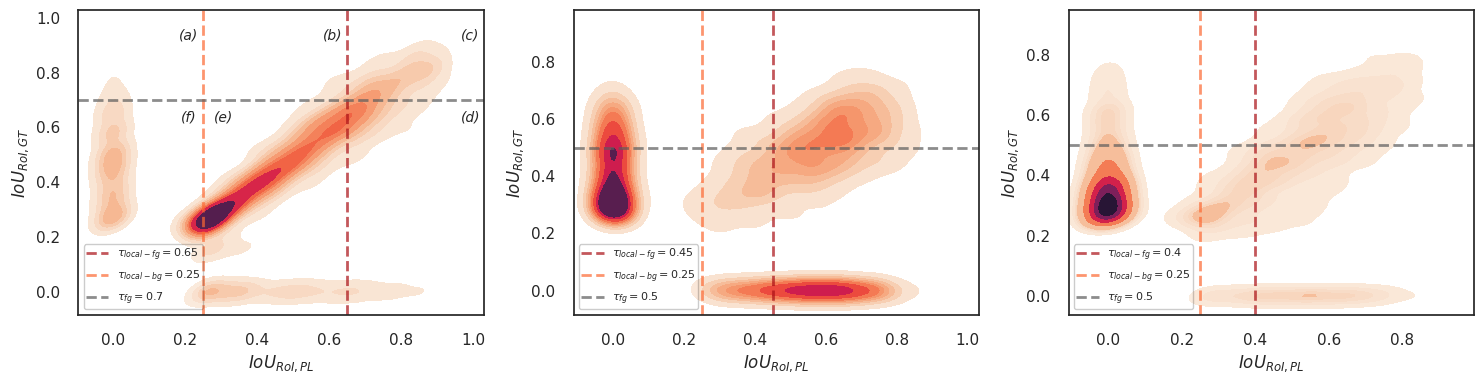

In [12]:
def get_kde_plot(df, class_name, ax, epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = (1439-(24*epoch_num)) if epoch_num != None else 0

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter 
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < gt_thresh['BG']))
    valid_mask = class_mask & epoch_mask & ignore_bg_mask
 
    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

    sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap=cmap, palette="rocket_r", shade=True, bw_adjust=.5, ax=ax)
    ax.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color=sns.color_palette("Reds")[-1], label="$\\tau_{local-fg}=var$".replace('var', str(pl_thresh['FG'][class_name])), alpha = 0.7, lw=2)
    ax.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color=sns.color_palette('YlOrRd')[-3], label="$\\tau_{local-bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
    ax.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color=sns.color_palette("Greys")[-2], label="$\\tau_{fg}=var$".replace('var', str(gt_thresh['FG'][class_name])), alpha = 0.7, lw=2)
    # ax.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)
    ax.set_xlabel('$IoU_{RoI,PL}$', fontsize=12)
    ax.set_ylabel('$IoU_{RoI,GT}$', fontsize=12)
    legend = ax.legend(frameon=True, fontsize=8, loc='lower left', borderpad=0.2, framealpha = 0.2)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    
    if class_name=='Car':
        edge_color = 'white'
        ax.text(0.184, 0.92, '(a)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.582, 0.92, '(b)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.966, 0.92, '(c)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.966, 0.62, '(d)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.28, 0.62, '(e)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2, 'edgecolor': edge_color})
        ax.text(0.188, 0.62, '(f)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2, 'edgecolor': edge_color})


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

get_kde_plot(df, 'Car', epoch_num=0.5, ax=axes[0]) # 0.5
get_kde_plot(df, 'Pedestrian', epoch_num=14, ax=axes[1]) #14
get_kde_plot(df, 'Cyclist', epoch_num=24, ax=axes[2]) #24

fig.tight_layout()
fig.savefig(fname="ious_kde.png", transparent=False, bbox_inches='tight')
plt.show()

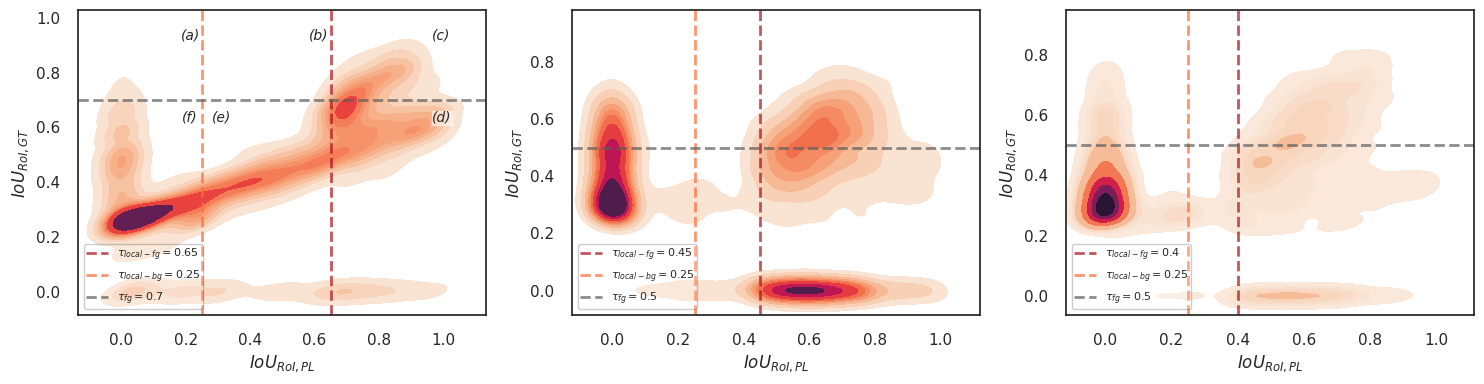

In [10]:
def get_uc_kde_plot(df, class_name, ax, epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = (1439-(24*epoch_num)) if epoch_num != None else 0

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter 
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < gt_thresh['BG']))
    valid_mask = class_mask & epoch_mask & ignore_bg_mask

    # calibrate UC IoUs
    iou_roi_pl = torch.Tensor(df['iou_roi_pl'])[valid_mask]
    uc_mask = (iou_roi_pl < pl_thresh['FG'][class_name]) & (iou_roi_pl > pl_thresh['BG'])
    iou_roi_pl[uc_mask] = (iou_roi_pl[uc_mask] - pl_thresh['BG']) / (pl_thresh['FG'][class_name] - pl_thresh['BG'])
    
    valid_df = pd.DataFrame({'iou_roi_pl': iou_roi_pl, 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

    sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap=cmap, palette="rocket_r", shade=True, bw_adjust=.5, ax=ax)
    ax.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color=sns.color_palette("Reds")[-1], label="$\\tau_{local-fg}=var$".replace('var', str(pl_thresh['FG'][class_name])), alpha = 0.7, lw=2)
    ax.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color=sns.color_palette('YlOrRd')[-3], label="$\\tau_{local-bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
    ax.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color=sns.color_palette("Greys")[-2], label="$\\tau_{fg}=var$".replace('var', str(gt_thresh['FG'][class_name])), alpha = 0.7, lw=2)
    # ax.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)
    ax.set_xlabel('$IoU_{RoI,PL}$', fontsize=12)
    ax.set_ylabel('$IoU_{RoI,GT}$', fontsize=12)
    legend = ax.legend(frameon=True, fontsize=8, loc='lower left', borderpad=0.2, framealpha = 0.2)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    
    if class_name=='Car':
        edge_color = 'white'
        ax.text(0.184, 0.92, '(a)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.582, 0.92, '(b)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.966, 0.92, '(c)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.966, 0.62, '(d)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.28, 0.62, '(e)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2, 'edgecolor': edge_color})
        ax.text(0.188, 0.62, '(f)', style='italic', fontsize=10, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2, 'edgecolor': edge_color})


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

get_uc_kde_plot(df, 'Car', epoch_num=0.5, ax=axes[0]) # 0.5
get_uc_kde_plot(df, 'Pedestrian', epoch_num=14, ax=axes[1]) #14
get_uc_kde_plot(df, 'Cyclist', epoch_num=24, ax=axes[2]) #24

fig.tight_layout()
fig.savefig(fname="ious_uc_kde.png", transparent=False, bbox_inches='tight')
plt.show()

## [Draft] Trying to plot bivariate KDE plot for IoU wrt pl and gt, along with weights 

In [ ]:
def get_joint_plot(df, class_name, fig_title="Default", plot_type="joint", epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = 1439-(24*epoch_num)

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < pl_thresh['BG']))
    valid_mask = class_mask & epoch_mask & ignore_bg_mask

    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})
    weight_labels = ['<0.2', '<0.4', '<0.6', '<0.8', '<0.1']
    valid_df['grouped_weights'] = pd.cut(valid_df['weights'], bins=np.arange(0,1.2,0.2), labels=weight_labels)
    if plot_type=='kde':
        # fig = plt.figure(figsize=(15,8))
        g = sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, hue=valid_df.grouped_weights, cmap=cmap, shade=True, bw_adjust=.5, cbar=False)
        plt.show()
    else:
        if fig_title=='Before':
            color = _cmap(1) # baseline always has weights = 1
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", color=color, xlim=-0.01, ylim=-0.01, legend=False, palette="rocket_r", s=10)
        else:
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", hue='weights', xlim=-0.01, ylim=-0.01, legend=False, palette="rocket_r", s=10)
        g.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)

        plt.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color='red', label="$\\tau_{local-fg}=var$".replace('var', str(pl_thresh['FG'][class_name])), alpha = 0.7, lw=2)
        plt.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color='orange', label="$\\tau_{local-bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
        plt.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color='red', label="$\\tau_{fg}=var$".replace('var', str(gt_thresh['FG'][class_name])), alpha = 0.7, lw=2)
        plt.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)

        legend = plt.legend(frameon=True, fontsize=8, loc='lower left', borderpad=0.2, framealpha = 0.7)
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')

        # Make space for the colorbar
        g.fig.subplots_adjust(right=.92)
        # Define a new Axes where the colorbar will go
        cax = g.fig.add_axes([.94, .25, .02, .6])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=cmap)
        # Draw the colorbar
        g.fig.colorbar(points, cax=cax).set_label("Weights")
        plt.show()
    return g

car_plot_after = get_joint_plot(df, 'Car', "After", plot_type='kde', epoch_num=0.50)



## ----------------------DND-------------------------

In [ ]:
# convert list to tensors
iou_roi_pl = torch.Tensor(df['iou_roi_pl'])
iou_roi_gt = torch.Tensor(df['iou_roi_gt'])
pred_scores = torch.sigmoid(torch.Tensor(df['pred_scores'])) # normlalise pred scores
class_labels = torch.Tensor(df['class_labels'])
iteration = torch.Tensor(df['iteration'])
print("Total iterations: ", iteration[-1].item())

# map (0,1439) iterations to (1,8), can be changed later
last_iter = int(max(df['iteration']))
interval_range = last_iter // 8
mapped_iteration = torch.Tensor([int(max(1, min((iter+(interval_range-1))//interval_range, 8))) for iter in df['iteration']])

# create classwise masks and extract their corresponding scores
class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
scores_df = pd.DataFrame()
scores_df = {'iou_roi_pl': {'Car': None, 'Pedestrian': None, 'Cyclist': None}, 
            'iou_roi_gt': {'Car': None, 'Pedestrian': None, 'Cyclist': None}, 
            'pred_scores': {'Car': None, 'Pedestrian': None, 'Cyclist': None},
            'mapped_iteration': {'Car': None, 'Pedestrian': None, 'Cyclist': None}}
for class_name, class_val in class_to_num.items():
    scores_df['iou_roi_pl'][class_name] = iou_roi_pl[class_labels==class_val]
    scores_df['iou_roi_gt'][class_name] = iou_roi_gt[class_labels==class_val]
    scores_df['pred_scores'][class_name] = pred_scores[class_labels==class_val]
    scores_df['mapped_iteration'][class_name] = mapped_iteration[class_labels==class_val]
    
    print(scores_df['iou_roi_pl'][class_name].shape, scores_df['iou_roi_gt'][class_name].shape, 
        scores_df['pred_scores'][class_name].shape, scores_df['mapped_iteration'][class_name].shape)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
class_name = "Pedestrian"
x = scores_df['iou_roi_pl'][class_name][scores_df['iou_roi_pl'][class_name] > 0.25]
g = scores_df['mapped_iteration'][class_name][scores_df['iou_roi_pl'][class_name] > 0.25].int()
df = pd.DataFrame()
df['IoU between ROI and PL'] = x
df['Train interval'] = g

# # Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Train interval", hue="Train interval", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "IoU between ROI and PL",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "IoU between ROI and PL", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "IoU between ROI and PL")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.show()